In [193]:
#FTCS scheme


In [231]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"

In [233]:
# Some functions for computing 1st and 2nd derivatives (use only interior points)
def ddx(f, dx):
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[1:-1,2:] - f[1:-1,:-2]) / (2.0 * dx)
    return result

def ddy(f, dy):
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[2:,1:-1] - f[:-2,1:-1]) / (2.0 * dy)
    return result

def laplacian(f, dx, dy):
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (
        (f[1:-1,2:] - 2.0*f[1:-1,1:-1] + f[1:-1,:-2]) / dx**2 +
        (f[2:,1:-1] - 2.0*f[1:-1,1:-1] + f[:-2,1:-1]) / dy**2
    )
    return result

def div(u, v, dx, dy):
    return ddx(u, dx) + ddy(v, dy)


In [235]:
def poisson(p, dx, dy, rhs):
    tol = 1e-5
    err = 100
    maxIt = 50
    beta = 1
    it = 0
    while err > tol and it < maxIt:
        # top wall
        p[-1,:] = 0
        # bottom wall
        p[0,:] = p[1,:]
        # left wall 
        p[:,0] = p[:,1]
        # right wall
        p[:,-1] = p[:,-2]

        pk = np.copy(p)
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                rhs_val = -(dx * dy)**2 * rhs[j,i] + dy**2 * (p[j,i+1] + p[j,i-1]) + dx**2 * (p[j+1,i] + p[j-1,i])
                rhs_val *= 1.0 / (2.0 * (dx**2 + dy**2))
                p[j,i] = rhs_val
        err = np.linalg.norm(p.ravel() - pk.ravel())
        it += 1
    return err


In [237]:
#problem spec
lx = 1.0
ly = 1.0
nx = 32
ny = 32
x = np.linspace(0,lx,nx)
dx = x[1] - x[0]
y = np.linspace(0,ly,ny)  #32*32 grid
dy = y[1] - y[0]

xx,yy = np.meshgrid(x,y)



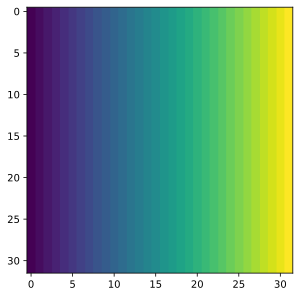

In [239]:
plt.imshow(xx)


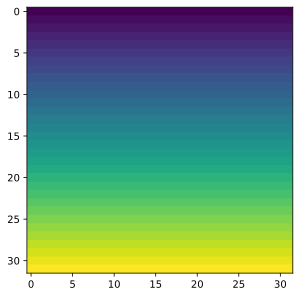

In [241]:

plt.imshow(yy)

In [243]:
#condition and flow prop
Uwall = 1.0 #top wall moving, rest at rest
Vwall = 0.0
nu = 0.05
# stability condition (generally done at worst-case scenario)
dt1 = 0.5 / (nu * (1/dx/dx + 1/dy/dy))
dt2 = 2 * nu / (Uwall*Uwall + Vwall*Vwall)  # corrected multiplication
dt = min(dt2, dt1)
print("for stability max dt = ", dt,"s")
Reynolds = Uwall*lx/nu
print("Reynolds No. is",Reynolds)

for stability max dt =  0.005202913631633714 s
Reynolds No. is 20.0


In [245]:
u = np.zeros([ny, nx])
v = np.zeros([ny,nx])
p = np.zeros([ny,nx])

In [247]:
#time advance
t =0.0
tend = 4000*dt 
u_history = []  # list of u arrays over time
v_history = []  # list of v arrays over time
while t < tend:
    # boundary conditions on top wall
    u[-1,:] = Uwall # (y,x) form we want all y values to be max
    v[-1,:] = Vwall
    #bottom wall
    u[0,:] = 0.0 
    v[0,:] = 0.0 
    #right wall
    u[:,-1] = 0.0
    v[:,-1] = 0.0
    #left wall
    u[:,0] = 0.0
    v[:,0] = 0.0
    # x- momentum 
    Cux = ddx(u*u, dx)
    Cuy = ddy(u*v, dy)
    Cvx = ddx(v*u, dx)
    Cvy = ddx(v*v, dy)
    
    uRHS = -Cux - Cuy + nu*laplacian(u,dx,dy)
    vRHS = -Cvx - Cvy + nu*laplacian(v,dx,dy)

    ut = u + dt*uRHS
    vt = v + dt*vRHS #non mass conserving field
    prhs = div(uRHS,vRHS,dx,dy) + div(u,v,dx,dy)/dt
    err = poisson(p,dx,dy,prhs)
    dpdx =ddx(p,dx)
    dpdy = ddy(p,dy)

    u = u + dt*uRHS - dt*dpdx
    v = v+ dt*vRHS - dt*dpdy
    u_history.append(u)
    v_history.append(v)
    t = t+dt
    

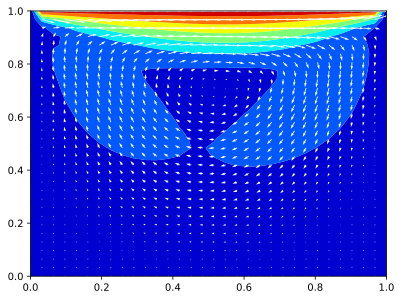

In [248]:
vel = np.sqrt(u**2 + v**2)
plt.contourf(xx,yy,vel,cmap="jet")
plt.quiver(xx,yy,u,v, color ="w")

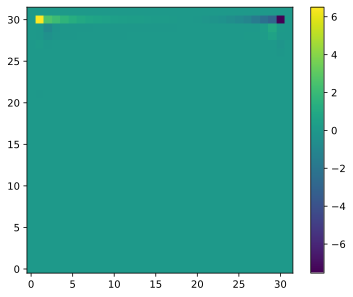

In [249]:
#check for continuity
divu=div(u,v,dx,dy)
plt.imshow(divu,origin='lower')
plt.colorbar()

MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\adity\AppData\Local\Temp\ipykernel_24476\603994601.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  return contour.collections + [quiv]


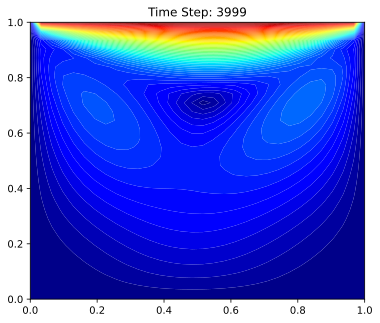

In [250]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig, ax = plt.subplots(figsize=(6,5))

# Initial frame
vel = np.sqrt(u_history[0]**2 + v_history[0]**2)
contour = ax.contourf(xx, yy, vel, levels=50, cmap="jet")
quiv = ax.quiver(xx, yy, u_history[0], v_history[0], color="w")

def update(frame):
    ax.clear()
    vel = np.sqrt(u_history[frame]**2 + v_history[frame]**2)
    contour = ax.contourf(xx, yy, vel, levels=50, cmap="jet")
    quiv = ax.quiver(xx, yy, u_history[frame], v_history[frame], color="w")
    ax.set_title(f"Time Step: {frame}")
    return contour.collections + [quiv]

ani = animation.FuncAnimation(fig, update, frames=len(u_history), interval=50, blit=False)
ani.save("cfd.gif")
plt.show()
